In [1]:
import sys
import os
import copy
current_dir = os.getcwd()
sys.path.append(current_dir[:-9])

In [2]:
import importlib

# 1) Tell the helper that we really want console logs
os.environ["LOG_TO_CONSOLE"] = "true"

| # | Method (constraint\_*) | Intention *(informal)* | Key Z3 variables it touches |
|---|-------------------------|-----------------------|-----------------------------|
| 1 | `constraint_injective_mapping` | At every **timestep** each logical qubit is mapped to **exactly one** available physical qubit, and two logical qubits can **never share** the same physical qubit. | `pi[q][t]` |
| 2 | `constraint_avoid_collisions` | Impose a **partial order** on the execution times: if two gates touch a common logical qubit, the one listed earlier in the circuit must **finish no later than** (transition-based mode) **or strictly before** (real-time mode) the later gate. | `time[g]` |
| 3 | `constraint_mapping_and_space_consistency` | Tie together the **“where”** and **“when”** coordinates: when gate *g* is scheduled at `time[g] == t`, its `space[g]` must equal the **current physical qubit(s)** that the logical operands map to in `pi[*][t]`. <br>• For 2-qubit gates, `space[g]` indexes an **edge**. <br>• For 1-qubit gates, it indexes a **node**. | `time[g]`, `space[g]`, `pi` |
| 4 | `constraint_no_SWAP_before_swap_duration` | A **SWAP** takes `swap_duration` cycles. Therefore **no** `sigma[e][t]` may be true for `t < swap_duration – 1`; the first SWAP can only **finish** at the earliest allowed timestep. | `sigma` |
| 5 | `constraint_no_SWAP_overlap_same_edge` | Same edge cannot finish two SWAPs **closer than** `swap_duration` apart (prevents *“queueing”* two swaps on the same wire before the first is done). | `sigma` |
| 6 | `constraint_no_SWAP_overlap_adjacent_edge` | Two edges that **share a qubit** cannot host **overlapping SWAPs** (hardware can’t drive two CZ-pulses that touch the same island simultaneously). | `sigma` |
| 7 | `constraint_no_SWAP_overlap_gates` <br>*--only when not transition-based--* | A SWAP must **not overlap in time** with **any other gate** that uses either of the same physical qubits. Prevents the router from *“half-swapping”* while, say, applying a single-qubit rotation on one end. | `sigma`, `time`, `space` |
| 8 | `constraint_mapping_unchanged` | If **no SWAP finishes** on a physical qubit at timestep *t*, that qubit’s logical payload **stays put** for timestep *t + 1*. | `pi`, `sigma` |
| 9 | `constraint_mapping_transformed` | Conversely, when a SWAP on edge *(i, j)* **does finish** at *t*, any logical qubit that was on **i moves to j** (and vice-versa) at *t + 1*. | `pi`, `sigma` |
| 10 | `constraint_no_SWAP_outside_gates` <br>*--added only when `hard_island = True`--* | **Intended meaning:** “All SWAPs must stay **inside the initial physical island** — you may not recruit relay qubits that were **not part** of the mapping at *t = 0*.” | `pi`, `sigma` |



- 1-3 guarantee a coherent spacetime embedding of gates
- 4-7 prevent physically impossible overlaps
- 8-9 update the logical-to-physical mapping consistently
- 10 (when fixed) optionally locks routing inside the initial island


Attempting to get QDevice(line-4,num qubits=4)'s transpiled swap for gates: ('H', 'CX', 'SWAP') - quantum_resources.py - get_transpiled_swap()
Quantum Device: line-4
 - Available Qubits: [0, 1, 2, 3]
 - connectivity: Graph with 4 nodes and 3 edges
 - quantum_resources.py - describe()


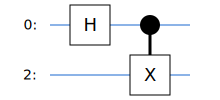

In [ ]:
import networkx as nx
import time
from qrew.simulation.refactor.quantum import QuantumCircuit, QuantumInstruction, LayoutSynthesizer
from qrew.simulation.refactor.quantum_gates import *
from qrew.simulation.refactor.resources import QuantumDevice,QuantumResource

g = nx.Graph(); g.add_edges_from([(0,1),(1,2),(2,3)])
dev = QuantumDevice("line-4", g, gate_set=("H","CX","SWAP"))


qc = QuantumCircuit(3, instructions=[])
qc.add_instruction(gate=H(),  indices=(0,))
 # Should route through q1
qc.add_instruction(gate=CX(), indices=(0,2))   
print(qc.instructions) 
qc.draw()

In [ ]:
res_with_constraint = QuantumResource(
    quantum_circuit=copy.deepcopy(qc),
    LS_parameters={
        "transition based": False,
        "hard_island":      True,     
        "epsilon":          0.3,
        "objective":        "depth",
    },
)


alloc = dev.allocate(res_with_constraint)



resource.LS_parameters: {'transition based': False, 'hard_island': True, 'epsilon': 0.3, 'objective': 'depth'} - quantum_resources.py - allocate()
Starting layout synthesis (objective=depth, transition_based=False, epsilon=0.3) - quantum_resources.py - allocate()
Starting solver with max_attempts=50, max_depth=10000 - quantum.py - solve()
Attempting maximal depth 2...
Contraint initial island added: relay qubits forbidden - quantum.py - add_constraints()
Found solution at depth=2, model depth=2, on attempt #1 - quantum.py - solve()
Layout synthesis time completed in 0:00:00.023030 after 1 attempts - quantum.py - solve()
Initial qubit mapping: (1, 2, 0) - quantum.py - post_process()
Final qubit mapping: (1, 2, 0) - quantum.py - post_process()
Objective result: 2 - quantum.py - post_process()
Available qubits before allocation: [0, 1, 2, 3] - quantum_resources.py - allocate()
Marking qubits (1, 2, 0) as unavailable on device 'line-4' - quantum_resources.py - allocate()
Available qubits a

[<QuantumInstruction name='H' qargs=(1,)>, <QuantumInstruction name='CX' qargs=(1, 0)>]


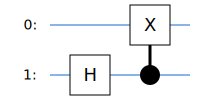

In [16]:
transpiled_circ = alloc.transpiled_circuit
assert qc != transpiled_circ
print(transpiled_circ.instructions)
transpiled_circ.draw()

In [15]:
qc.instructions

[<QuantumInstruction name='H' qargs=(0,)>,
 <QuantumInstruction name='CX' qargs=(0, 2)>]

In [17]:
# run again with hard_island == False
dev2 = QuantumDevice("line-4", g, gate_set=("H","CX","SWAP"))


res_no_constraint = QuantumResource(
    quantum_circuit=copy.deepcopy(qc),
    LS_parameters={
        "transition based": False,
        "hard_island":      False,     
        "epsilon":          0.3,
        "objective":        "depth",
    },
)


alloc = dev2.allocate(res_no_constraint)


Attempting to get QDevice(line-4,num qubits=4)'s transpiled swap for gates: ('H', 'CX', 'SWAP') - quantum_resources.py - get_transpiled_swap()
Quantum Device: line-4
 - Available Qubits: [0, 1, 2, 3]
 - connectivity: Graph with 4 nodes and 3 edges
 - quantum_resources.py - describe()
resource.LS_parameters: {'transition based': False, 'hard_island': False, 'epsilon': 0.3, 'objective': 'depth'} - quantum_resources.py - allocate()
Starting layout synthesis (objective=depth, transition_based=False, epsilon=0.3) - quantum_resources.py - allocate()
Starting solver with max_attempts=50, max_depth=10000 - quantum.py - solve()
Attempting maximal depth 2...
Found solution at depth=2, model depth=2, on attempt #1 - quantum.py - solve()
Layout synthesis time completed in 0:00:00.021444 after 1 attempts - quantum.py - solve()
Initial qubit mapping: (0, 2, 1) - quantum.py - post_process()
Final qubit mapping: (0, 2, 1) - quantum.py - post_process()
Objective result: 2 - quantum.py - post_process()


[<QuantumInstruction name='H' qargs=(0,)>, <QuantumInstruction name='CX' qargs=(0, 1)>]


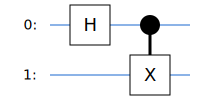

In [18]:
transpiled_circ2 = alloc.transpiled_circuit
assert qc != transpiled_circ2
print(transpiled_circ2.instructions)
transpiled_circ2.draw()

1. Initial mapping (chosen by the solver) can be `(0→0, 1→2)`– that’s inside the "island" {0, 2}
2. To execute the `CX(0,1)` the router inserts a SWAP on edge `(2, 3)` (uses qubit 3, which is outside the island)
3. Because `constraint_no_SWAP_outside_gates` is a no-op, the model is still deemed satisfiable even though it clearly violates the intended rule.


```python
assert ([2, 3], t_swap) in synth.results["SWAPs"]   # <-- proves outside-island SWAP occurred
```

Logical circuit:


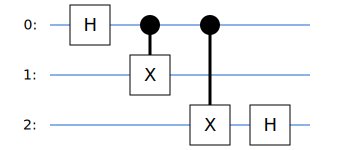

In [4]:
from qrew.simulation.refactor.resources import QuantumDevice,QuantumResource,QuantumAllocation
def line4():
    g = nx.Graph()
    g.add_edges_from([(0,1), (1,2), (2,3)])
    return g

dev = QuantumDevice(
    device_name="line-4",
    connectivity=line4(),
    gate_set=("H", "CX", "SWAP"),   # exact .name strings from quantum_gates.py
)

toy_circ = QuantumCircuit(qubit_count=3, instructions=[])
toy_circ.add_instruction(gate=H(),   indices=(0,))
toy_circ.add_instruction(gate=CX(),  indices=(0,1))
toy_circ.add_instruction(gate=CX(),  indices=(0,2))   # non-adjacent on line-4
toy_circ.add_instruction(gate=H(),   indices=(2,))

print("Logical circuit:")
toy_circ.draw()


In [5]:
res = QuantumResource(
    quantum_circuit=copy.deepcopy(toy_circ),
    LS_parameters={
        "transition based": False,
        "hard_island":      True,      # adds *buggy* constraint
        "epsilon":          0.3,
        "objective":        "depth",
    },
)

allocation_buggy = dev.allocate(res)
compiled_buggy   = allocation_buggy.transpiled_circuit

print("\nCompiled circuit with ORIGINAL constraint:")
compiled_buggy.draw()
buggy_touched = {idx for i in compiled_buggy.instructions for idx in i.gate_indices}
print("Physical qubits touched  →", buggy_touched)

Attempting maximal depth 4...

Compiled circuit with ORIGINAL constraint:
Physical qubits touched  → {1, 2, 3}


In [ ]:
# ─────────────────────────── helpers ────────────────────────────
def line_graph(n):
    """0-1-2-…-(n-1)"""
    g = nx.Graph()
    g.add_edges_from([(i, i + 1) for i in range(n - 1)])
    return g

def build_toy_device():
    return QuantumDevice(
        device_name="line-4",
        connectivity=line_graph(4),
        gate_set=("H", "CX", "SWAP"),
    )

def build_toy_circuit():
    """Logical qubits labelled 0,1,2 – but CX(0,2) is *non-adjacent*."""
    qc = QuantumCircuit(qubit_count=3, instructions=[])
    add = qc.add_instruction
  
    add(QuantumInstruction(H(),(0,)))
    add(QuantumInstruction(CX(),(0,1)))
    add(QuantumInstruction(CX(),(0,2)))
    add(QuantumInstruction(H(),(2)))


    return qc

toy_device   = build_toy_device()
toy_circuit  = build_toy_circuit()

print("Logical circuit:")
toy_circuit.draw()          # Cirq-style ASCII

res = QuantumResource(
    quantum_circuit=deepcopy(toy_circuit),
    LS_parameters={
        "transition based": False,   # easier to see scheduling
        "hard_island":      True,    # will add buggy constraint
        "epsilon":          0.3,
        "objective":        "depth",
    },
)

allocation = toy_device.allocate(res)          #   <- uses buggy constraint
compiled   = allocation.transpiled_circuit

print("\nCompiled circuit (BUGGY constraint):")
compiled.draw()

# Which physical qubits did it touch?
touched = {idx for instr in compiled.instructions for idx in instr.gate_indices}
print("Touched qubits:", touched)

In [12]:
from qrew.simulation.refactor.resources import QuantumDevice

# 4-qubit line: 0 - 1 - 2 - 3
toy_dev_graph = nx.path_graph(4)          # edges: (0,1), (1,2), (2,3)


def build_toy_device():
    """Line-4 topology: 0-1-2-3."""
    g = nx.path_graph(4)
    gate_set = ("H", "CX", "SWAP")           # names only – QuantumDevice handles lookup
    return QuantumDevice("line4", g, gate_set=gate_set)
def build_toy_circuit():
    """Two-qubit circuit that *needs* the qubits adjacent."""
    qc = QuantumCircuit(qubit_count=2, instructions=[
        QuantumInstruction(H(),  (0,)),
        QuantumInstruction(CX(), (0, 1)),
    ])
    return qc
def run_layout_synthesis(device, circuit):
    """Convenience wrapper that returns the LS results-dict."""
    _, init_map, _, _, results = device.layout_synthesis(
        circuit,
        transition_based=True,   # makes swap_duration = 1 ⟹ simpler schedule
        hard_island=True,        # ➟ buggy constraint is *supposed* to fire
        epsilon=0.3,
        objective="depth",
    )
    return init_map, results


def swap_uses_outside_qubit(edge, initial_island):
    """True if either endpoint of *edge* is outside the initial mapping."""
    return any(q not in initial_island for q in edge)



device  = build_toy_device()
circuit = build_toy_circuit()

initial_island, results = run_layout_synthesis(device, circuit)
swap_edges = [tuple(edge) for edge, _ in results["swaps"]]

# ---- the tell-tale violation -----------------------------------------
offending = [
    edge for edge in swap_edges
    if swap_uses_outside_qubit(edge, initial_island)
]

# If the constraint *worked*, `offending` would be empty
print(f"violations: {offending}")
assert offending, (
    "constraint_no_SWAP_outside_gates correctly blocked out-of-island SWAPs "
    "— test should now be updated / removed."
)

print("\nInitial mapping:", initial_island)
print("All SWAPs:", swap_edges)
print("Outside-island SWAPs (should NOT be allowed):", offending)


Attempting maximal depth 1...
Layout synthesis time: 0:00:00.006247
violations: []


AssertionError: constraint_no_SWAP_outside_gates correctly blocked out-of-island SWAPs — test should now be updated / removed.